## Parâmetros de treinamento

* **Pontos de colocação por época (amostragem uniforme):**

  * **Domínio (PDE):** **4.000**
  * **Contorno (Neumann):**

    * $x=L$: $\sigma_{xx}=\sin(\pi y/L)$, $\sigma_{xy}=0$ → **2.500**
    * $y=L$: $\sigma_{yy}=0$, $\sigma_{xy}=0$ → **2.000**
    * $y=0$: $\sigma_{xy}=0$ (apoio sem atrito) → **2.000**
  * **Avaliação (plots):** **10.000** pontos (grade 100×100)
* **Função de ativação:** `Tanh`
* **Otimizadores:** **Adam** (`lr = 1e-3`, **4.000 épocas**) → **L-BFGS** (`max_iter=800`, `strong_wolfe`) para refinamento
* **Material (plano de tensão):** $E=1.0$, $\nu=0.3$
  $\mu=\dfrac{E}{2(1+\nu)}$, $\lambda=\dfrac{2\mu\nu}{1-\nu}=\dfrac{E\nu}{1-\nu^2}$
  **Domínio:** $L=1.0$

## Estrutura da rede (FNN)

* **Camadas:** **2–30–30–30–2**

  * **Entrada:** 2 nós $(x,y)$
  * **Ocultas:** 3 camadas com **30 neurônios** cada (`tanh`)
  * **Saída:** 2 nós $(u_x,u_y)$
* **Inicialização:** Xavier/Glorot
* **Parâmetros treináveis:** \~**2,0 mil**

## Condições de contorno

* **Esquerda $x=0$ — engaste (HARD):**
  Impostas **exatamente** via transformação da saída:
  $u_x = x\,\hat u_x$ e $u_y = x\,y\,\hat u_y$ ⇒ $u_x(0,y)=0$, $u_y(0,y)=0$.
* **Base $y=0$ — apoio sem atrito:**
  $u_y=0$ (**HARD**, pois $u_y=x\,y\,\hat u_y$) e $\sigma_{xy}=0$ (**SOFT**)
* **Direita $x=L$ — tração senoidal (SOFT):**
  $\sigma_{xx}(L,y)=\sin(\pi y/L)$, $\sigma_{xy}(L,y)=0$
* **Topo $y=L$ — livre (SOFT):**
  $\sigma_{yy}(x,L)=0$, $\sigma_{xy}(x,L)=0$

## Resultados qualitativos

* **$u_x$:** máximo na lateral direita, com pico próximo ao meio da altura, seguindo a forma $\sin(\pi y/L)$ e decaindo em direção ao engaste.
* **$u_y$:** padrão coerente com o efeito de Poisson: contração na parte superior e leve expansão na inferior.
* **Curva de perda:** queda estável com Adam (escala log) e novo rebaixamento após L-BFGS; sem oscillations patológicas.

[Adam]    0  loss=4.1014e+00
[Adam]  200  loss=8.9891e-01
[Adam]  400  loss=6.4629e-01
[Adam]  600  loss=4.6106e-01
[Adam]  800  loss=3.7895e-01
[Adam] 1000  loss=3.3316e-01
[Adam] 1200  loss=2.9634e-01
[Adam] 1400  loss=2.5717e-01
[Adam] 1600  loss=1.9811e-01
[Adam] 1800  loss=1.7394e-01
[Adam] 2000  loss=1.4863e-01
[Adam] 2200  loss=1.2640e-01
[Adam] 2400  loss=1.0863e-01
[Adam] 2600  loss=9.4598e-02
[Adam] 2800  loss=8.7306e-02
[Adam] 3000  loss=8.1968e-02
[Adam] 3200  loss=7.9681e-02
[Adam] 3400  loss=7.4824e-02
[Adam] 3600  loss=7.3209e-02
[Adam] 3800  loss=7.2274e-02

[LBFGS] Refinando...
[LBFGS] loss_final = 7.1734e-02


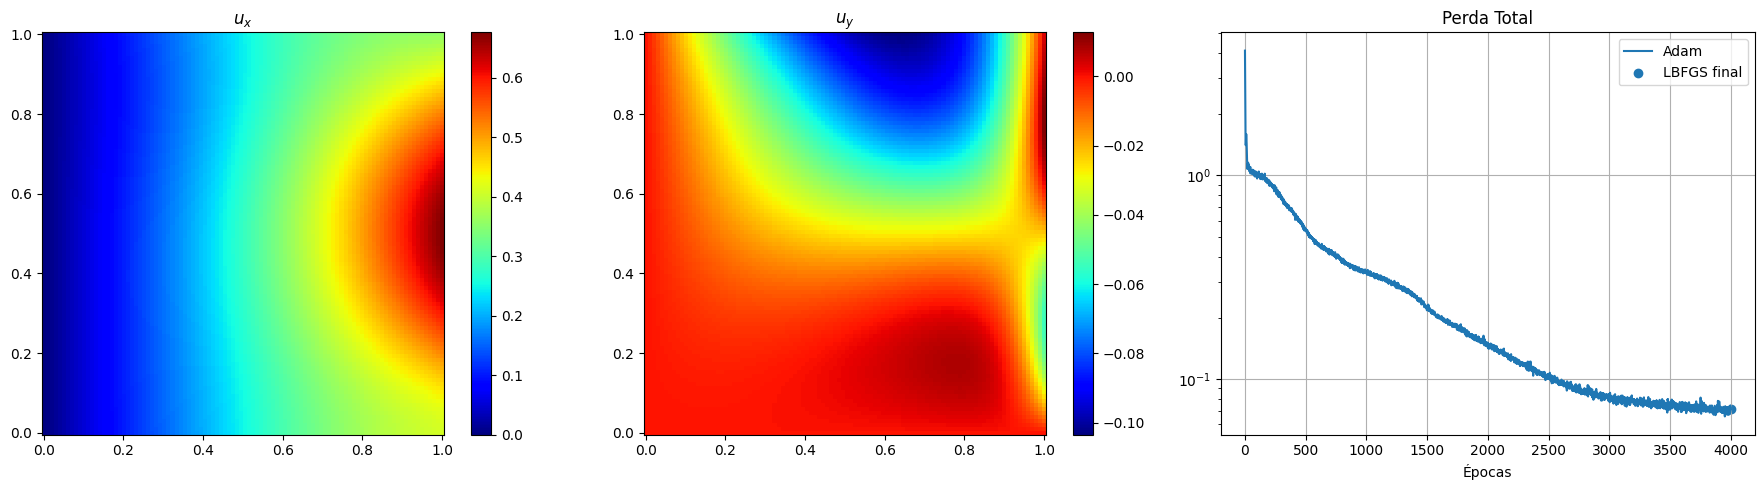

In [7]:
import torch, torch.nn as nn, torch.autograd as autograd
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----- Material (plano de tensão) -----
E, nu = 1.0, 0.3
mu = E/(2*(1+nu))
lambda_ = 2*mu*nu/(1-nu)      # = E*nu/(1-nu**2)
L = 1.0

# ----- Rede com imposição HARD das CCs de deslocamento -----
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.act = nn.Tanh()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1])
                                     for i in range(len(layers)-1)])
        for lin in self.layers:
            nn.init.xavier_uniform_(lin.weight); nn.init.zeros_(lin.bias)

    def core(self, x):  # MLP "cru"
        for i in range(len(self.layers)-1):
            x = self.act(self.layers[i](x))
        return self.layers[-1](x)  # retorna [ux_hat, uy_hat]

    def forward(self, xy):
        """
        Impõe hard:
          - ux(0,y)=0  -> ux = x * ux_hat
          - uy(0,y)=0 e uy(x,0)=0 -> uy = x*y * uy_hat
        """
        xy = xy.clone()
        x = xy[:, :1]
        y = xy[:, 1:2]
        u_hat = self.core(xy)
        ux = x * u_hat[:, :1]
        uy = x * y * u_hat[:, 1:2]
        return torch.cat([ux, uy], dim=1)

model = PINN([2, 30, 30, 30, 2]).to(device)

# ----- utilitários -----
def stresses_at(xy):
    xy = xy.requires_grad_(True)
    u = model(xy)
    ux, uy = u[:, :1], u[:, 1:]
    gux = autograd.grad(ux, xy, torch.ones_like(ux), create_graph=True)[0]
    guy = autograd.grad(uy, xy, torch.ones_like(uy), create_graph=True)[0]
    exx, exy = gux[:, :1], gux[:, 1:2]
    eyx, eyy = guy[:, :1], guy[:, 1:2]
    sxx = lambda_*(exx+eyy) + 2*mu*exx
    syy = lambda_*(exx+eyy) + 2*mu*eyy
    sxy = mu*(exy+eyx)
    return sxx, syy, sxy

# ----- PDE (equilíbrio) -----
def pde_loss(n_int=4000):
    xy = torch.rand((n_int,2), device=device, requires_grad=True)*L
    sxx, syy, sxy = stresses_at(xy)
    gsxx = autograd.grad(sxx, xy, torch.ones_like(sxx), create_graph=True)[0]
    gsyy = autograd.grad(syy, xy, torch.ones_like(syy), create_graph=True)[0]
    gsxy = autograd.grad(sxy, xy, torch.ones_like(sxy), create_graph=True)[0]
    fx = gsxx[:, :1] + gsxy[:, 1:2]
    fy = gsxy[:, :1] + gsyy[:, 1:2]
    return (fx.pow(2).mean() + fy.pow(2).mean())

# ----- BCs (soft para tensões) -----
def right_traction_loss(n=2500):
    # x=L: sxx = sin(pi*y/L), sxy = 0
    y = torch.rand((n,1), device=device)*L
    x = torch.ones_like(y)*L
    xy = torch.cat([x,y],1)
    sxx, _, sxy = stresses_at(xy)
    target = torch.sin(torch.pi * y / L)
    return (sxx - target).pow(2).mean() + sxy.pow(2).mean()

def top_free_loss(n=2000):
    # y=L: syy = 0, sxy = 0
    x = torch.rand((n,1), device=device)*L
    y = torch.ones_like(x)*L
    xy = torch.cat([x,y],1)
    _, syy, sxy = stresses_at(xy)
    return syy.pow(2).mean() + sxy.pow(2).mean()

def base_support_shear_free(n=2000):
    # y=0: apoio sem atrito -> sxy = 0  (uy=0 já é HARD)
    x = torch.rand((n,1), device=device)*L
    y = torch.zeros_like(x)
    xy = torch.cat([x,y],1)
    _, _, sxy = stresses_at(xy)
    return sxy.pow(2).mean()

# ----- Loss total (pesos equilibrados) -----
def total_loss():
    w_pde, w_r, w_t, w_b = 1.0, 10.0, 10.0, 10.0
    return (w_pde*pde_loss()
            + w_r*right_traction_loss()
            + w_t*top_free_loss()
            + w_b*base_support_shear_free())

# ----- Treino -----
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
hist = []
for ep in range(4000):
    opt.zero_grad()
    loss = total_loss()
    loss.backward(); opt.step()
    hist.append(loss.item())
    if ep % 200 == 0:
        print(f"[Adam] {ep:4d}  loss={loss.item():.4e}")

# L-BFGS (refino)
def closure():
    opt_lbfgs.zero_grad()
    l = total_loss()
    l.backward()
    return l
opt_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=800, tolerance_grad=1e-9,
                              line_search_fn='strong_wolfe')
print("\n[LBFGS] Refinando...")
final_loss = opt_lbfgs.step(closure).item()
print(f"[LBFGS] loss_final = {final_loss:.4e}")

# ----- Visualização -----
with torch.no_grad():
    xg = torch.linspace(0,L,100, device=device)
    yg = torch.linspace(0,L,100, device=device)
    X,Y = torch.meshgrid(xg, yg, indexing='ij')
    XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    U = model(XY)
Ux = U[:,0].reshape(100,100).cpu().numpy()
Uy = U[:,1].reshape(100,100).cpu().numpy()
xx, yy = X.cpu().numpy(), Y.cpu().numpy()

fig, ax = plt.subplots(1,3, figsize=(18,5))
c1 = ax[0].pcolormesh(xx, yy, Ux, cmap=plt.cm.jet, shading='auto'); fig.colorbar(c1, ax=ax[0])
ax[0].set_title("$u_x$"); ax[0].set_aspect('equal')

c2 = ax[1].pcolormesh(xx, yy, Uy, cmap=plt.cm.jet, shading='auto'); fig.colorbar(c2, ax=ax[1])
ax[1].set_title("$u_y$"); ax[1].set_aspect('equal')

ax[2].plot(hist, label="Adam"); ax[2].set_yscale('log'); ax[2].grid(True)
ax[2].scatter(len(hist)-1, final_loss, label="LBFGS final")
ax[2].set_title("Perda Total"); ax[2].set_xlabel("Épocas"); ax[2].legend()
plt.tight_layout(); plt.show()
